In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib # For saving the model later

# Load the clean data
train_df = pd.read_csv('../data/processed/train_FD001_clean.csv')

print(f"Loaded Clean Data! Shape: {train_df.shape}")
train_df.head()

Loaded Clean Data! Shape: (20231, 45)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,...,s_14_mean,s_14_std,s_15_mean,s_15_std,s_17_mean,s_17_std,s_20_mean,s_20_std,s_21_mean,s_21_std
0,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,8134.194,2.651326,8.41334,0.025953,391.8,1.095445,38.958,0.073621,23.39302,0.033498
1,1,6,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,...,8133.040,0.958697,8.41160,0.025727,391.6,1.140175,38.942,0.051186,23.38260,0.031436
2,1,7,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,...,8133.206,0.643141,8.40472,0.023476,391.6,1.140175,38.962,0.086718,23.37336,0.021634
3,1,8,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,...,8132.774,1.149274,8.40268,0.022477,391.8,0.836660,38.966,0.086487,23.36664,0.034405
4,1,9,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,...,8131.146,3.205438,8.40360,0.020740,391.8,0.836660,39.000,0.077136,23.37318,0.038939


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- STEP 1: SPLIT BY ENGINE (Protect against Leakage) ---
def train_val_split_by_engine(df, test_size=0.2):
    # Get list of unique engines
    unique_units = df['unit_nr'].unique()
    
    # Shuffle indices
    np.random.seed(42)
    np.random.shuffle(unique_units)
    
    # Split the list of engines
    split_point = int(len(unique_units) * (1 - test_size))
    train_units = unique_units[:split_point]
    val_units = unique_units[split_point:]
    
    # Create the DataFrames
    train_set = df[df['unit_nr'].isin(train_units)]
    val_set = df[df['unit_nr'].isin(val_units)]
    
    return train_set, val_set

train_set, val_set = train_val_split_by_engine(train_df)

print(f"Training on {train_set['unit_nr'].nunique()} engines.")
print(f"Validating on {val_set['unit_nr'].nunique()} engines.")

Training on 80 engines.
Validating on 20 engines.


In [23]:
# --- STEP 2: DEFINE FEATURES (X) AND TARGET (y) ---
# We use the rolling mean/std columns + original sensor columns
features = [col for col in train_df.columns if col not in ['unit_nr', 'time_cycles', 'RUL']]
target = 'RUL'

X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]

# --- STEP 3: TRAIN MODEL ---
print("Training Random Forest... (This might take a minute)")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# --- STEP 4: EVALUATE ---
preds = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
r2 = r2_score(y_val, preds)

print(f"\nResults:")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R2 Score (Accuracy): {r2:.2f}")

Training Random Forest... (This might take a minute)

Results:
RMSE (Root Mean Squared Error): 44.62
R2 Score (Accuracy): 0.60


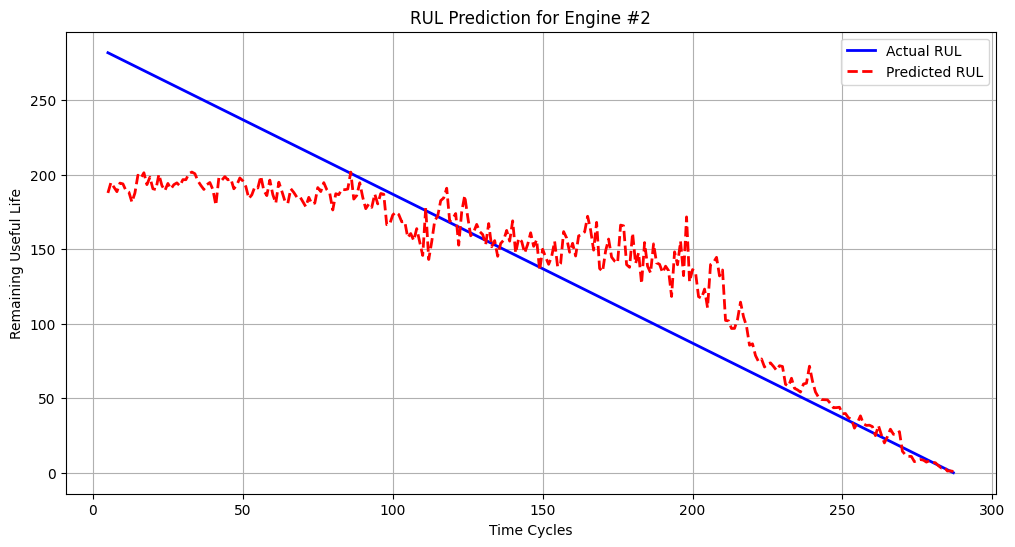

In [24]:
# Visual Check (The "Reality Check" Plot)

def plot_prediction(model, val_df, features, target):
    # Pick the first engine in the validation set to visualize
    unit_id = val_df['unit_nr'].unique()[0]
    single_engine_data = val_df[val_df['unit_nr'] == unit_id]
    
    X_single = single_engine_data[features]
    y_true = single_engine_data[target]
    y_pred = model.predict(X_single)
    
    plt.figure(figsize=(12, 6))
    
    # Plot Actual RUL (Blue)
    plt.plot(single_engine_data['time_cycles'], y_true, label='Actual RUL', color='blue', linewidth=2)
    
    # Plot Predicted RUL (Red Dashed)
    plt.plot(single_engine_data['time_cycles'], y_pred, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
    
    plt.title(f"RUL Prediction for Engine #{unit_id}")
    plt.xlabel("Time Cycles")
    plt.ylabel("Remaining Useful Life")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prediction(rf_model, val_set, features, target)

In [25]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. LOAD DATA ---
train_df = pd.read_csv('../data/processed/train_FD001_clean.csv')

# --- 2. ADD "SLOPE" FEATURES (The Lag Trick) ---
# This teaches the model: "Is the vibration rising FAST or SLOW?"
print("Generating Slope features...")
sensors_to_slope = ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']

for col in sensors_to_slope:
    # Calculate difference: (Current Value) - (Value 5 cycles ago)
    # This captures the *rate of change*
    train_df[f'{col}_slope'] = train_df.groupby('unit_nr')[col].diff(periods=5)

# Fill the empty first 5 rows with 0
train_df.fillna(0, inplace=True)

# --- 3. SPLIT DATA BY ENGINE (Prevent Leaking) ---
def train_val_split_by_engine(df, test_size=0.2):
    unique_units = df['unit_nr'].unique()
    np.random.seed(42)
    np.random.shuffle(unique_units)
    
    split_point = int(len(unique_units) * (1 - test_size))
    train_units = unique_units[:split_point]
    val_units = unique_units[split_point:]
    
    train_set = df[df['unit_nr'].isin(train_units)]
    val_set = df[df['unit_nr'].isin(val_units)]
    return train_set, val_set

train_set, val_set = train_val_split_by_engine(train_df)

# --- 4. DEFINE FEATURES & TARGET ---
# We use all columns EXCEPT IDs and Target
features = [col for col in train_df.columns if col not in ['unit_nr', 'time_cycles', 'RUL']]
target = 'RUL'

X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]

print(f"Training on {X_train.shape[0]} rows with {len(features)} features (including slopes).")

# --- 5. TRAIN XGBOOST (The Upgrade) ---
print("Training XGBoost Model... (This is faster and smarter)")
xgb_model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# --- 6. EVALUATE ---
preds = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
r2 = r2_score(y_val, preds)

print(f"\nFINAL RESULTS:")
print(f"RMSE: {rmse:.2f} (Lower is better)")
print(f"R2 Score: {r2:.2f} (Higher is better)")



Generating Slope features...
Training on 16020 rows with 52 features (including slopes).
Training XGBoost Model... (This is faster and smarter)

FINAL RESULTS:
RMSE: 43.61 (Lower is better)
R2 Score: 0.62 (Higher is better)


In [27]:
# --- 7. SAVE THE BEST MODEL ---
# Only save if it's actually decent (e.g., > 0.60)
import os
if r2 > 0.60:
    print("\nSaving high-accuracy model to artifacts...")
    #Create the folder if it doesn't exist
    os.makedirs('../artifacts', exist_ok=True)

    joblib.dump(xgb_model, '../artifacts/model.pkl')
    joblib.dump(features, '../artifacts/features.pkl') 
    # Saving list of features so App knows what to expect
    print("Saved!")
else:
    print("\nScore too low, not saving.")


Saving high-accuracy model to artifacts...
Saved!
